In [1]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

## Experiment 4 - Cubic Lorenz System

List of experiments:

a) 2xCO2

b) High Emissions

c) Mid. Emissions

d) Overshoot

#### Setup and Run Experiments

In [2]:
# ----------------------------------------------------------------------
# Parameters
sigma, beta  = 10.0, 8 / 3
rho_base     = 28.0
dt           = 0.01
delta_rho    = 1.0/dt
alpha        = 1/1000
t_max_pert   = 5
t_max_scen   = 250
t_vec_pert   = np.arange(0.0, t_max_pert + dt, dt)
t_vec_scen   = np.arange(0.0, t_max_scen + dt, dt)
n_steps_pert = t_vec_pert.size
n_steps_scen = t_vec_scen.size
ensemble_size = 5_000
eps = 4

# ----------------------------------------------------------------------
def lorenz(state, rho):
  x, y, z = state[:, 0], state[:, 1], state[:, 2]
  dx = sigma * (y - x)
  dy = -(z + alpha*np.pow(z,3))*x + rho*x - y
  dz = x * y - beta * z
  return np.stack([dx, dy, dz], axis=1)

def rk4_step(state, rho, dt):
  k1 = lorenz(state,                 rho)
  k2 = lorenz(state + 0.5*dt*k1,     rho)
  k3 = lorenz(state + 0.5*dt*k2,     rho)
  k4 = lorenz(state +       dt*k3,   rho)
  return state + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

scenarios = ['Abrupt','High Emissions','Mid. Emissions','Overshoot']

In [3]:
# ----------------------------------------------------------------------
# Spin-up, required for all scenarios
state0 = np.random.normal(0.0, 5.0, size=(ensemble_size, 3))
warm_steps = 5_000
for _ in range(warm_steps):
  dW      = np.random.normal(0.0, 2, size=state0.shape)
  state0  = rk4_step(state0, rho_base, dt) + eps * np.sqrt(dt) * dW

baseline_mean = state0.mean(axis=0)

### Run scenarios

In [4]:
rho = {}
for i, scen in enumerate(scenarios):
  rho[scen] = np.zeros(len(t_vec_scen))
  for j, t in enumerate(t_vec_scen):
    rho[scen][j] = emulator_utils.Lorenz_rho(t, exp=i)

In [5]:
state_ensemble, state_mean = {}, {}
for scen in scenarios:
  print(scen)
  # Baseline and perturbed ensembles share identical initial states
  state = state0.copy()

  # Storage for means
  state_ensemble[scen] = np.zeros((ensemble_size, n_steps_scen, 3))
  state_ensemble[scen][:,0,:] = state
  state_mean[scen] = np.zeros((n_steps_scen, 3))
  state_mean[scen][0] = state.mean(axis=0)

  # ----------------------------------------------------------------------
  # Time integration
  for n in range(1, n_steps_scen):
    rho_t = rho[scen][n]
    dW = np.random.normal(0.0, 1, size=state0.shape)

    # RK4 deterministic advance + stochastic term
    state_ensemble[scen][:,n,:] = rk4_step(state_ensemble[scen][:,n-1,:], rho_t, dt) + eps * np.sqrt(dt) * dW
    state_mean[scen][n] = state_ensemble[scen][:,n,:].mean(axis=0)

    if n % 10_000 == 0:
      print(f'\t{n}')

  #emulator_utils.save_error(state_ensemble, 'exp4_ensemble')
  #emulator_utils.save_error(state_mean, 'exp4_mean')

Abrupt
	10000
	20000
High Emissions
	10000
	20000
Mid. Emissions
	10000
	20000
Overshoot
	10000
	20000


In [6]:
z_ensemble, z_std = {}, {}
for scen in scenarios:
  z_ensemble[scen] = state_ensemble[scen][:,:,2].copy()
  #z_std[scen] = np.std(state_ensemble[scen][:,:,2],axis=0)

In [7]:
z_mean = {}
for scen in scenarios:
  z_mean[scen] = state_mean[scen][:,2].copy()

In [9]:
from emulator_utils import brewer2_light
def Lorenz_plot(scenarios, Z_mean, Z_std, t_vec, T, save=False, fig_name=None):
  fig, ax = plt.subplots(1, 4, figsize=(16,4), constrained_layout=True, sharey=True)

  for i, scen in enumerate(scenarios):
    ax[i].plot(t_vec, Z_mean[scen], c=brewer2_light(0), lw=2, label='Mean')
    ax[i].fill_between(t_vec, Z_mean[scen] - Z_std[scen], Z_mean[scen] + Z_std[scen], alpha=0.5, color=brewer2_light(0), label=r'$\sigma$')

    ax[i].tick_params(axis='both', which='major', labelsize=18)
    ax[i].set_xlabel('Time',fontsize=20)

    if scen == 'Abrupt':
      title = r'\textit{Abrupt}'
    elif scen == 'High Emissions':
      title = r'\textit{High Emissions}'
    elif scen == 'Mid. Emissions':
      title = r'\textit{Mid. Emissions}'
    elif scen == 'Overshoot':
      title = r'\textit{Overshoot}'
    ax[i].set_title(title, fontsize=24, va="center")

  #ax[0].legend(fontsize=20)
  ax[0].set_ylabel(r'$\langle Z \rangle$',fontsize=24)
  

  if save:
    plt.savefig(f'Figures/{fig_name}.pdf',dpi=900)

  return

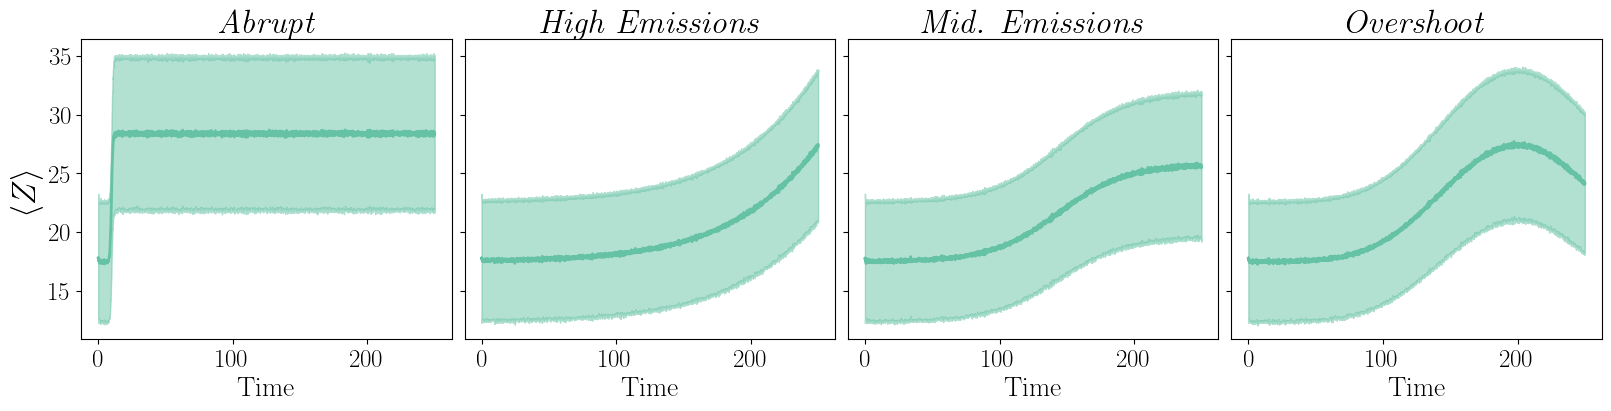

In [13]:
Lorenz_plot(scenarios, z_mean, z_std, t_vec_scen, 1, save=True, fig_name='expLorenz_scens_v1')

### Method 1: Pattern Scaling

In [80]:
n_choices = 10
rng = np.random.default_rng(1)

NRMSE_all_PS = {}
for train in scenarios:
    print(train)
    NRMSE_all_PS[train] = {}
    z_ensemble_train = z_ensemble[train]

    for test in scenarios:
        if train == test:
            continue

        NRMSE_all_PS[train][test] = []

    for n in range(1, ensemble_size + 1, ensemble_size//50):
        NRMSE_temp = {}
        for test in scenarios:
            if train == test:
                continue

            NRMSE_temp[test] = []

        for _ in range(n_choices):
            # Choose n ensemble members
            idx = rng.choice(ensemble_size, size=n, replace=False)
            z_choice = z_ensemble_train[idx]

            # Calculate operator
            operator_temp = emulator_utils.method_0b_gen_PS(np.mean(z_choice, axis=0), rho[train])

            for test in scenarios:
                if train == test:
                    continue
                #z_mean_test = emulator_utils.open_pkl(f'exp4b_{scen}_z_mean')
                z_mean_test = z_mean[test]

                # Calculate error tested against the full ensemble (i.e. avg. forcing)
                z_pred_temp = operator_temp @ rho[test].reshape(1,-1)
                NRMSE_temp[test].append(emulator_utils.calc_NRMSE(z_mean_test.reshape(1,-1), z_pred_temp))

        # Save average error over trials
        for test in scenarios:
            if train == test:
                continue
            NRMSE_all_PS[train][test].append(np.mean(NRMSE_temp[test]))

    emulator_utils.save_error(NRMSE_all_PS, 'exp4b_1_PS_error_ensemble')

Abrupt
High Emissions
Mid. Emissions
Overshoot


### Method 2: FDT

In [8]:
state_base_ensemble, state_pert_ensemble = np.zeros((ensemble_size, n_steps_pert, 3)), np.zeros((ensemble_size, n_steps_pert, 3))

# Baseline and perturbed ensembles share identical initial states
delta       = 50 * dt
state_base_ensemble[:,0,:]  = state0.copy()
state_pert_ensemble[:,0,:]  = state0.copy()
state_pert_ensemble[:,0,1] += delta * state_base_ensemble[:,0,0]

# Storage for means
mean_base = np.zeros((n_steps_pert, 3))
mean_pert = np.zeros_like(mean_base)
mean_base[0] = state_base_ensemble[:,0,:].mean(axis=0)
mean_pert[0] = state_pert_ensemble[:,0,:].mean(axis=0)

# ----------------------------------------------------------------------
# Time integration
for n in range(1, n_steps_pert):
  # identical noise for baseline & perturbed trajectories
  dW = np.random.normal(0.0, 1, size=state0.shape)

  # RK4 deterministic advance + identical stochastic kick
  state_base_ensemble[:,n,:] = rk4_step(state_base_ensemble[:,n-1,:], rho_base, dt) + eps * np.sqrt(dt) * dW
  state_pert_ensemble[:,n,:] = rk4_step(state_pert_ensemble[:,n-1,:], rho_base, dt) + eps * np.sqrt(dt) * dW

  mean_base[n] = state_base_ensemble[:,n,:].mean(axis=0)
  mean_pert[n] = state_pert_ensemble[:,n,:].mean(axis=0)

# ----------------------------------------------------------------------
# FDT estimate of response
R_FDT = (mean_pert - mean_base) / delta
labels = ["x response", "y response", "z response"]

In [30]:
z_base_ensemble = state_base_ensemble[:,:,2].copy()
z_pert_ensemble = state_pert_ensemble[:,:,2].copy()

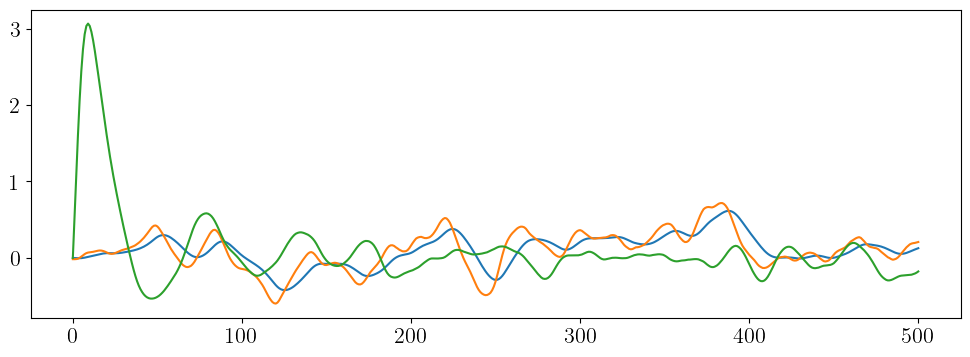

In [83]:
#test = 'Abrupt'
#pred_anom = np.convolve(R_mean[:,2], (rho[test] - 28), mode='full')[:len(t_vec_scen)] * dt
#plt.plot(pred_anom + baseline_mean[2])
plt.plot(R_mean)

In [84]:
w0 = np.array([baseline_mean[2]])
n_steps = len(t_vec_scen)
rho_base = 28
n_choices = 10
delta = 50 * dt

NRMSE_all_FDT = {}
for test in scenarios:
    NRMSE_all_FDT[test] = []

for n in range(1, ensemble_size + 1, ensemble_size//50):
    NRMSE_temp = {}
    for test in scenarios:
        NRMSE_temp[test] = []

    for _ in range(10):
        # Choose n ensemble members
        idx = rng.choice(ensemble_size, size=n, replace=False)
        z_choice_base = z_base_ensemble[idx]
        z_choice_pert = z_pert_ensemble[idx]

        # Calculate operator
        R_choice = np.mean(z_choice_pert - z_choice_base, axis=0) / delta

        for test in scenarios:
            # Calculate error tested against the full ensemble (i.e. avg. forcing)
            pred_anom_temp = np.convolve(R_choice, (rho[test] - rho_base), mode='full')[:len(t_vec_scen)] * dt
            z_pred_temp = pred_anom_temp + baseline_mean[2]
            NRMSE_temp[test].append(np.mean(emulator_utils.calc_NRMSE(z_mean_test.reshape(1,-1), z_pred_temp.reshape(1,-1))))

    # Save average error over trials
    for test in scenarios:
        NRMSE_all_FDT[test].append(np.mean(NRMSE_temp[test]))

    emulator_utils.save_error(NRMSE_all_FDT, 'exp4b_2_FDT_error_ensemble')

### Method 3: Deconvolution

In [88]:
n_choices = 10
rng = np.random.default_rng(1)

NRMSE_all_deconv = {}
for train in scenarios:
    print(train)
    NRMSE_all_deconv[train] = {}
    z_ensemble_train = z_ensemble[train]
    
    for test in scenarios:
        if train == test:
            continue
            
        NRMSE_all_deconv[train][test] = []
        
    for n in range(1, ensemble_size + 1, ensemble_size//50):
        NRMSE_temp = {}
        for test in scenarios:
            if train == test:
                continue
            
            NRMSE_temp[test] = []

        for _ in range(n_choices):
            # Choose n ensemble members
            idx = rng.choice(ensemble_size, size=n, replace=False)
            z_choice = z_ensemble_train[idx]

            # Calculate operator
            R_choice = emulator_utils.method_3a_deconvolve(np.mean(z_choice, axis=0)[0:501], rho[train][0:501], dt)

            for test in scenarios:
                if train == test:
                    continue
                z_mean_test =  z_mean[test]

                # Calculate error tested against the full ensemble (i.e. avg. forcing)
                pred_anom_temp = np.convolve(R_choice, (rho[test] - rho_base), mode='full')[:len(t_vec_scen)] * dt
                z_pred_temp = pred_anom_temp + baseline_mean[2]
                NRMSE_temp[test].append(np.mean(emulator_utils.calc_NRMSE(z_mean_test.reshape(1,-1), z_pred_temp.reshape(1,-1))))

        # Save average error over trials
        for test in scenarios:
            if train == test:
                continue
            NRMSE_all_deconv[train][test].append(np.mean(NRMSE_temp[test]))
            
    emulator_utils.save_error(NRMSE_all_deconv, 'exp4b_3_deconv_error_ensemble')

Abrupt
High Emissions
Mid. Emissions
Overshoot


### Method 4: Modal Fit

In [93]:
n_choices = 10
rng = np.random.default_rng(1)
n_modes, n_boxes = 1, 1

NRMSE_all_fit = {}
for train in scenarios:
    print(train)
    NRMSE_all_fit[train] = {}
    z_ensemble_train = z_ensemble[train]
    
    for test in scenarios:
        if train == test:
            continue
            
        NRMSE_all_fit[train][test] = []
        
    for n in range(1, ensemble_size + 1, ensemble_size//50):
        NRMSE_temp = {}
        for test in scenarios:
            if train == test:
                continue
            
            NRMSE_temp[test] = []

        for _ in range(n_choices):
            # Choose n ensemble members
            idx = rng.choice(ensemble_size, size=n, replace=False)
            z_choice = z_ensemble_train[idx]

            # Calculate operator
            R_choice = emulator_utils.method_4d_fit_complex(np.mean(z_choice, axis=0)[0:501], rho[train][0:501], t_vec_pert, dt, n_modes, n_boxes)

            for test in scenarios:
                if train == test:
                    continue
                z_mean_test = z_mean[test]

                # Calculate error tested against the full ensemble (i.e. avg. forcing)
                pred_anom_temp = np.convolve(R_choice.flatten(), (rho[test] - rho_base), mode='full')[:len(t_vec_scen)] * dt
                z_pred_temp = pred_anom_temp + baseline_mean[2]
                NRMSE_temp[test].append(np.mean(emulator_utils.calc_NRMSE(z_mean_test.reshape(1,-1), z_pred_temp.reshape(1,-1))))

        # Save average error over trials
        for test in scenarios:
            if train == test:
                continue
            NRMSE_all_fit[train][test].append(np.mean(NRMSE_temp[test]))
            
    emulator_utils.save_error(NRMSE_all_fit, 'exp4b_4_fit_error_ensemble')

Abrupt


/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary

High Emissions


/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary

Mid. Emissions


/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary

Overshoot


/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  # Emulate a scenario with DMD
/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary

### Method 5: DMD

In [89]:
w0 = np.array([baseline_mean[2]])
n_steps = len(t_vec_scen)

n_choices = 10
rng = np.random.default_rng(1)

NRMSE_all_DMD = {}
for train in scenarios:
    print(train)
    NRMSE_all_DMD[train] = {}
    z_ensemble_train = z_ensemble[train]
    
    for test in scenarios:
        if train == test:
            continue
            
        NRMSE_all_DMD[train][test] = []
        
    for n in range(1, ensemble_size + 1, ensemble_size//50):
        NRMSE_temp = {}
        for test in scenarios:
            if train == test:
                continue
            
            NRMSE_temp[test] = []

        for _ in range(n_choices):
            # Choose n ensemble members
            idx = rng.choice(ensemble_size, size=n, replace=False)
            z_choice = z_ensemble_train[idx]

            # Calculate operator
            A_temp, B_temp = emulator_utils.method_1a_DMD(np.mean(z_choice, axis=0), rho[train])

            for test in scenarios:
                if train == test:
                    continue
                z_mean_test = z_mean[test]

                # Calculate error tested against the full ensemble (i.e. avg. forcing)
                z_pred_temp = emulator_utils.emulate_DMD(rho[test], A_temp, B_temp, w0, n_steps)
                NRMSE_temp[test].append(emulator_utils.calc_NRMSE(z_mean_test.reshape(1,-1), z_pred_temp))

        # Save average error over trials
        for test in scenarios:
            if train == test:
                continue
            NRMSE_all_DMD[train][test].append(np.mean(NRMSE_temp[test]))
            
    emulator_utils.save_error(NRMSE_all_DMD, 'exp4b_5_DMD_error_ensemble')

Abrupt
High Emissions
Mid. Emissions
Overshoot


### Method 6: EDMD

In [90]:
w0 = np.array([baseline_mean[2]])
n_steps = len(t_vec_scen)

n_choices = 10
rng = np.random.default_rng(1)
w_dict = emulator_utils.Vector_Dict(method='hermite', degree=3)
F_dict = emulator_utils.Vector_Dict(method='hermite', degree=3)

NRMSE_all_EDMD = {}
for train in scenarios:
    print(train)
    NRMSE_all_EDMD[train] = {}
    z_ensemble_train = z_ensemble[train]
    
    for test in scenarios:
        if train == test:
            continue
            
        NRMSE_all_EDMD[train][test] = []
        
    for n in range(1, ensemble_size + 1, ensemble_size//50):
        NRMSE_temp = {}
        for test in scenarios:
            if train == test:
                continue
            
            NRMSE_temp[test] = []

        for _ in range(n_choices):
            # Choose n ensemble members
            idx = rng.choice(ensemble_size, size=n, replace=False)
            z_choice = z_ensemble_train[idx]

            # Calculate operator
            A_temp, B_temp = emulator_utils.method_1b_EDMD(np.mean(z_choice, axis=0), rho[train], w_dict, F_dict)

            for test in scenarios:
                if train == test:
                    continue
                z_mean_test = z_mean[test]

                # Calculate error tested against the full ensemble (i.e. avg. forcing)
                z_pred_temp = emulator_utils.emulate_EDMD(rho[test], A_temp, B_temp, w0, n_steps, 1, w_dict, F_dict)
                NRMSE_temp[test].append(emulator_utils.calc_NRMSE(z_mean_test.reshape(1,-1), z_pred_temp))

        # Save average error over trials
        for test in scenarios:
            if train == test:
                continue
            NRMSE_all_EDMD[train][test].append(np.mean(NRMSE_temp[test]))
            
    emulator_utils.save_error(NRMSE_all_EDMD, 'exp4b_6_EDMD_error_ensemble')

Abrupt
High Emissions
Mid. Emissions
Overshoot


In [11]:
n_choices = 10
rng = np.random.default_rng(1)
n_modes, n_boxes = 1, 1

# Calculate operator
train = 'Overshoot'
R_deconv = emulator_utils.method_3a_deconvolve(np.mean(z_ensemble[train], axis=0)[0:501], rho[train][0:501], dt)
R_fit = emulator_utils.method_4d_fit_complex(np.mean(z_ensemble[train], axis=0)[0:501], rho[train][0:501], t_vec_pert, dt, n_modes, n_boxes)

/Users/chriswomack/Documents/PhD/Project 1/emulator_utils.py:836: ComplexWarning: Casting complex values to real discards the imaginary part
  G_opt[:,i] = 1/alpha*jnp.exp(1/alpha*(lam + 1j*omega)*n)


In [35]:
z_base_ensemble[0:50,:]

array([[14.42232625, 15.47562082, 16.22541082, ..., 16.86371158,
        18.14580852, 18.49502867],
       [17.09139318, 18.50206874, 20.50144451, ..., 20.18282875,
        20.41071699, 21.49541102],
       [23.71369982, 25.75381277, 26.21430744, ..., 17.64819175,
        17.27418811, 16.10290292],
       ...,
       [21.57653965, 21.74545157, 21.52676004, ...,  6.7064756 ,
         8.06766693,  8.34863345],
       [19.07433095, 20.74909897, 21.90404312, ..., 15.84807253,
        15.15787447, 16.07685302],
       [26.23336099, 25.28958579, 24.18273236, ..., 18.37880413,
        18.38666905, 18.3095078 ]], shape=(50, 501))

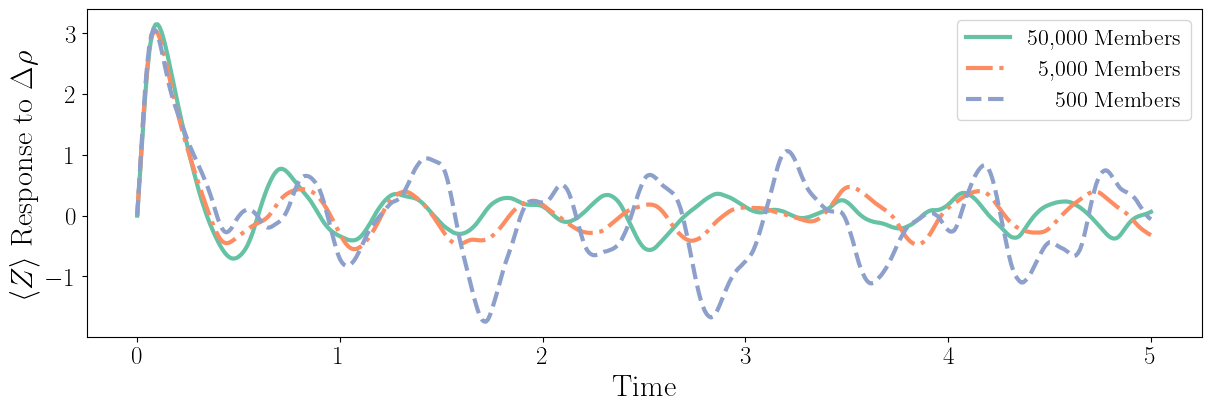

In [50]:
from emulator_utils import brewer2_light
R_mean = emulator_utils.open_error('R_mean')
R_50 = np.mean(z_pert_ensemble[0:50,:] - z_base_ensemble[0:50,:], axis=0)/delta
R_500 = np.mean(z_pert_ensemble[0:500,:] - z_base_ensemble[0:500,:], axis=0)/delta
fig, ax = plt.subplots(figsize=(12,4),layout='constrained')
dt = 0.01
t = np.arange(0,5+dt,dt)
ax.plot(t,R_mean, lw=3, c=brewer2_light(0), label='50,000 Members')
ax.plot(t,R_FDT[:,2], lw=3, c=brewer2_light(1), ls = '-.', label='5,000 Members')
ax.plot(t,R_500, lw=3, c=brewer2_light(2), ls='--', label = '500 Members')
legend = ax.legend()

max_shift = max([t.get_window_extent().width for t in legend.get_texts()])
for t in legend.get_texts():
  t.set_ha('right')  # ha is alias for horizontalalignment
  temp_shift = max_shift - t.get_window_extent().width
  t.set_position((temp_shift, 0))

ax.set_ylabel(r'$\langle Z \rangle$ Response to $\Delta \rho$',fontsize=22)
ax.set_xlabel('Time',fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('Figures/Z_response.pdf',dpi=900)

In [54]:
np.sqrt(np.mean((R_mean - R_FDT)**2))/np.abs(np.mean(R_mean,axis=0))*100

array([413.91682842])

In [57]:
np.sqrt(np.mean((R_mean - R_500)**2))/np.abs(np.mean(R_mean,axis=0))*100

array([754.02013103])